In [1]:
import pandas as pd
import numpy as np
import os
import joblib
import seaborn as sns
import toml
import matplotlib.pyplot as plt
import joblib
from copy import deepcopy
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score
from statsmodels.stats.multitest import multipletests
from m6anet.utils.builder import build_dataloader, random_fn
from m6anet.utils.data_utils import NanopolishDS

%load_ext autoreload
%autoreload 2

In [2]:
cols = ["Model Name", "Accuracy", "ROC AUC", "PR AUC", "Criteria"]
folds = ["1", "2", "3", "4", "5"]

In [3]:
def compute_roc_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    return roc_auc


def compute_pr_auc(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred, pos_label=1)
    pr_auc = auc(recall, precision)
    return pr_auc


def plot_roc_curve(y_true, y_pred, label, ax):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    sns.lineplot(fpr, tpr, lw=1, ax=ax, alpha=0.3, label="{} - AUC: %0.2f".format(label) % (roc_auc))


def plot_pr_curve(y_true, y_pred, label, ax):
    precision, recall, _ = precision_recall_curve(y_true, y_pred, pos_label=1)
    pr_auc = auc(recall, precision)
    sns.lineplot(recall, precision, lw=1, alpha=0.3, ax=ax, label="{} - AUC: %0.2f".format(label) % (pr_auc))
    
def customise_roc_pr_plots(axes, label_size=15, font_size=15, linewidth=5, patch_size=20):
    # Customizing plots
    for ax in axes:
        ax.xaxis.label.set_size(label_size)
        ax.yaxis.label.set_size(label_size)

        for axis in [ax.xaxis, ax.yaxis]:
            for tick in axis.get_major_ticks():
                tick.label.set_fontsize(font_size)

        plt.setp(ax.get_legend().get_texts(), fontsize='{}'.format(font_size))
        plt.setp(ax.lines, linewidth=linewidth)

    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')

    for ax in axes:
        for axis in [ax.xaxis, ax.yaxis]:
            axis.label.set_size(font_size)

    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')

    for ax in axes:
        ax.legend(loc='best', prop={'size': patch_size})

In [4]:
hct116_results = "/data03/christopher/m6anet_new_dataprep_results_cv/"
train_config = "../m6anet/model/configs/training_configs/m6a_classification_nanopolish/1_neighbor/oversampled.toml"
train_config = toml.load(train_config)

cv_dir = "/home/christopher/hct116_cv/"
all_models = os.listdir(hct116_results)
model = 'prod_pooling_1_neighbor'
df = []
model_dir = os.path.join(hct116_results, model)
selection_criterion = "pr_auc"

y_true = []
y_pred = []
min_reads = 20
pred_df = []
for fold_num in folds:
    cv_fold_fpath = os.path.join(cv_dir, fold_num)
    train_config_copy = deepcopy(train_config)
    fold_dir = os.path.join(model_dir, fold_num)
    
    train_config_copy["dataset"]["site_info"] = cv_fold_fpath
    
    _, _, val_dl = build_dataloader(train_config_copy, 25, verbose=False)
    data = val_dl.dataset.data_info
    result = joblib.load(os.path.join(fold_dir, "val_results_{}.joblib".format(selection_criterion)))
    y_true_fold, y_pred_fold = np.array(result["y_true"]), np.mean(np.array(result["y_pred"]), axis=0)

    assert(len(y_true_fold) == len(data))
    assert(np.all(data["modification_status"].values == y_true_fold))
    
    data["modification_probability"] = y_pred_fold
    pred_df.append(data)
    y_true.append(y_true_fold)
    y_pred.append(y_pred_fold)
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
pred_df = pd.concat(pred_df)
roc_auc, pr_auc = compute_roc_auc(y_true, y_pred), compute_pr_auc(y_true, y_pred)
print(roc_auc, pr_auc)

0.9213958980458541 0.4729359313429212


In [5]:
import json
from functools import partial
from multiprocessing import Pool
from tqdm.notebook import tqdm

def load_position(data_fpath, task):
    tx_id, tx_pos, start_pos, end_pos = task
    with open(data_fpath, 'r') as f:
        f.seek(start_pos, 0)
        json_str = f.read(end_pos - start_pos)
        pos_info = json.loads(json_str)[tx_id][str(tx_pos)]

        assert(len(pos_info.keys()) == 1)

        _, features = list(pos_info.items())[0]
        features = np.array(features)[:, [12, 13, 14, 15, 16, 17, 18, 19, 20]]
        features = features[np.random.choice(len(features), 20, replace=False)].reshape(1, 20, 9)
    return features

def load_positions(info_df, data_fpath, n_processes):
    tasks = (tuple(x) for _, x in info_df[["transcript_id", "transcript_position", "start", "end"]].iterrows())
    with Pool(n_processes) as p:
        features = [feature for feature in tqdm(p.imap(partial(load_position, data_fpath), tasks), 
                                                                  total=len(info_df))]
    return np.concatenate(features)

In [6]:
kmers = ('GGACT', 'GGACA', 'TGACT', 'GAACT')
df = pred_df[pred_df["kmer"].apply(lambda x: x[5:10]).isin(kmers)]
features = load_positions(df, "/home/christopher/hct116_dataprep_5_neighbors/data.json", 25)
proba = df["modification_probability"]

  0%|          | 0/29460 [00:00<?, ?it/s]

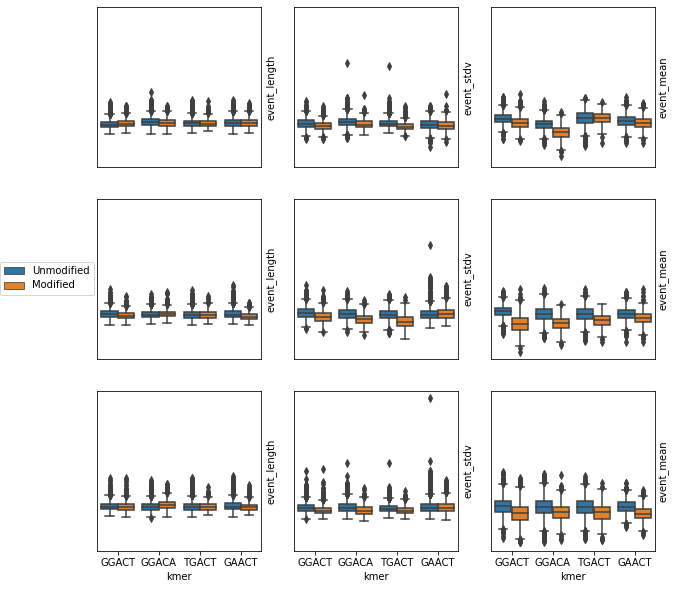

In [7]:
modification_status = (proba >= 0.8) * 1
norm_dict = joblib.load("../m6anet/model/norm_factors/norm_dict.joblib")
fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharey=True)

kmer_arr = df["kmer"].apply(lambda x: x[5:10]).reset_index(drop=True)
kmer_arr_full = df["kmer"].apply(lambda x: x[4:11]).reset_index(drop=True)
prediction = modification_status.values
prediction = np.array(["Modified" if x == 1 else "Unmodified" for x in prediction])
for i in range(3):
    for ax, idx, title in zip(axes[i], np.arange(3) + 3 * i, 
                              ['event_length', 'event_stdv', 'event_mean']):
        to_plot = []
        for kmer in kmers:
            mask = np.argwhere((kmer_arr == kmer).values).flatten()
            kmer_info = np.array([kmer[i:i+5] for kmer in kmer_arr_full[mask]])
            mean = np.array([norm_dict[seq][0][idx % 3] for seq in kmer_info])
            std = np.array([norm_dict[seq][1][idx %3] for seq in kmer_info])
            feature = (np.mean(features[mask, :, idx], axis=1) - mean) / std

            sub_df = pd.DataFrame({title: feature, 'kmer': np.repeat(kmer, len(feature)),
                       'prediction': prediction[mask]})
            to_plot.append(sub_df)
        to_plot = pd.concat(to_plot)
        sns.boxplot(x="kmer", y=title, hue="prediction", data=to_plot, ax=ax)
        ax.legend([],[], frameon=False)
        ax.yaxis.set_label_position("right")
        ax.set_yticks([])

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc = (0, 0.5), prop={"size":10})

for ax in axes[:-1]:
    for axis in ax:
        axis.set_xticks([])
        axis.set_xlabel(None)



<AxesSubplot:xlabel='kmer', ylabel='proportion modified'>

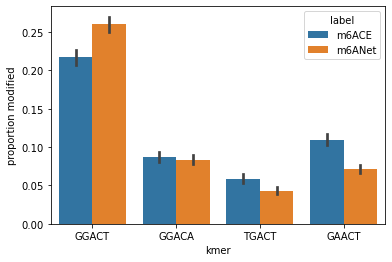

In [19]:
barplot_df = []
pred_df["is_modified"] = (pred_df["modification_probability"] >= 0.9) * 1
pred_df["kmer_midle"] = pred_df["kmer"].apply(lambda x: x[5:10])

for kmer in kmers:
    sub_df = pred_df[pred_df["kmer_midle"] == kmer]
    
    modified = np.sum(sub_df["modification_status"] == 1)
    unmodified = len(sub_df) - modified
    
    barplot_df.append(pd.DataFrame({'kmer': np.repeat(kmer, len(sub_df)), 
                                    'label': np.repeat('m6ACE', len(sub_df)),
                                    'proportion modified': np.append(np.ones(modified), np.zeros(unmodified))}))
    
    pred_modified = np.sum(sub_df["is_modified"] == 1)
    pred_umodified = len(sub_df) - pred_modified
    
    barplot_df.append(pd.DataFrame({'kmer': np.repeat(kmer, len(sub_df)), 
                                    'label': np.repeat('m6ANet', len(sub_df)),
                                    'proportion modified': np.append(np.ones(pred_modified), np.zeros(pred_umodified))}))    
barplot_df = pd.concat(barplot_df)

sns.barplot(x="kmer", y="proportion modified", hue='label', data=barplot_df)

<AxesSubplot:xlabel='kmer', ylabel='proportion modified'>

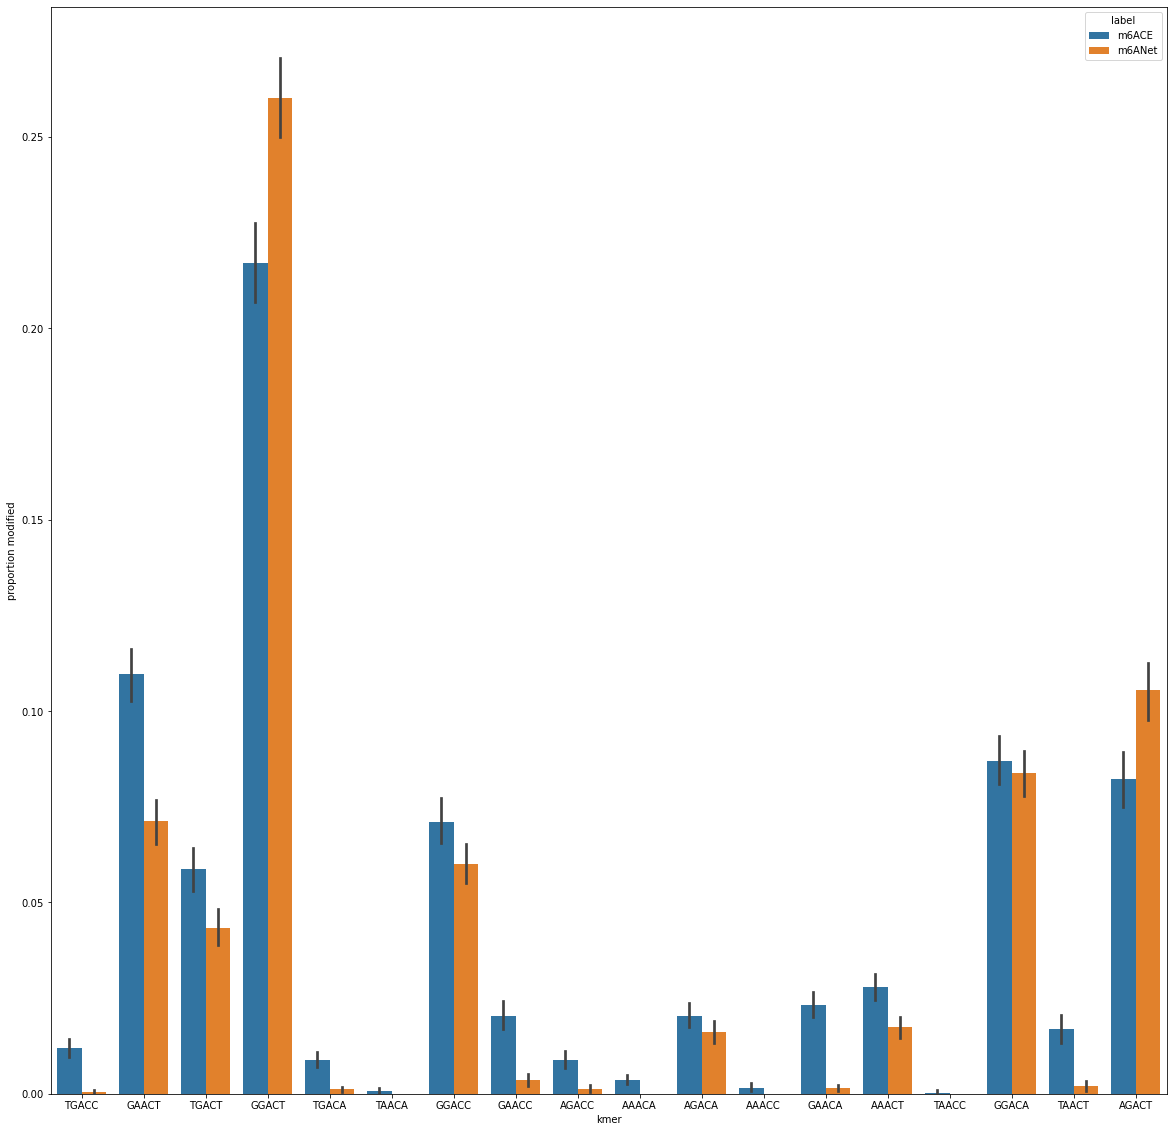

In [18]:
barplot_df = []
pred_df["is_modified"] = (pred_df["modification_probability"] >= 0.9) * 1
pred_df["kmer_midle"] = pred_df["kmer"].apply(lambda x: x[5:10])

for kmer in pred_df["kmer_midle"].unique():
    sub_df = pred_df[pred_df["kmer_midle"] == kmer]
    
    modified = np.sum(sub_df["modification_status"] == 1)
    unmodified = len(sub_df) - modified
    
    barplot_df.append(pd.DataFrame({'kmer': np.repeat(kmer, len(sub_df)), 
                                    'label': np.repeat('m6ACE', len(sub_df)),
                                    'proportion modified': np.append(np.ones(modified), np.zeros(unmodified))}))
    
    pred_modified = np.sum(sub_df["is_modified"] == 1)
    pred_umodified = len(sub_df) - pred_modified
    
    barplot_df.append(pd.DataFrame({'kmer': np.repeat(kmer, len(sub_df)), 
                                    'label': np.repeat('m6ANet', len(sub_df)),
                                    'proportion modified': np.append(np.ones(pred_modified), np.zeros(pred_umodified))}))    
barplot_df = pd.concat(barplot_df)

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
sns.barplot(x="kmer", y="proportion modified", hue='label', data=barplot_df)

In [6]:
hct116_results = "/data03/christopher/m6anet_new_dataprep_results_cv/"

m6anet


/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Logistic Regression 1 Neighbor


/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Mean Logistic Regression 0 Neighbor


/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


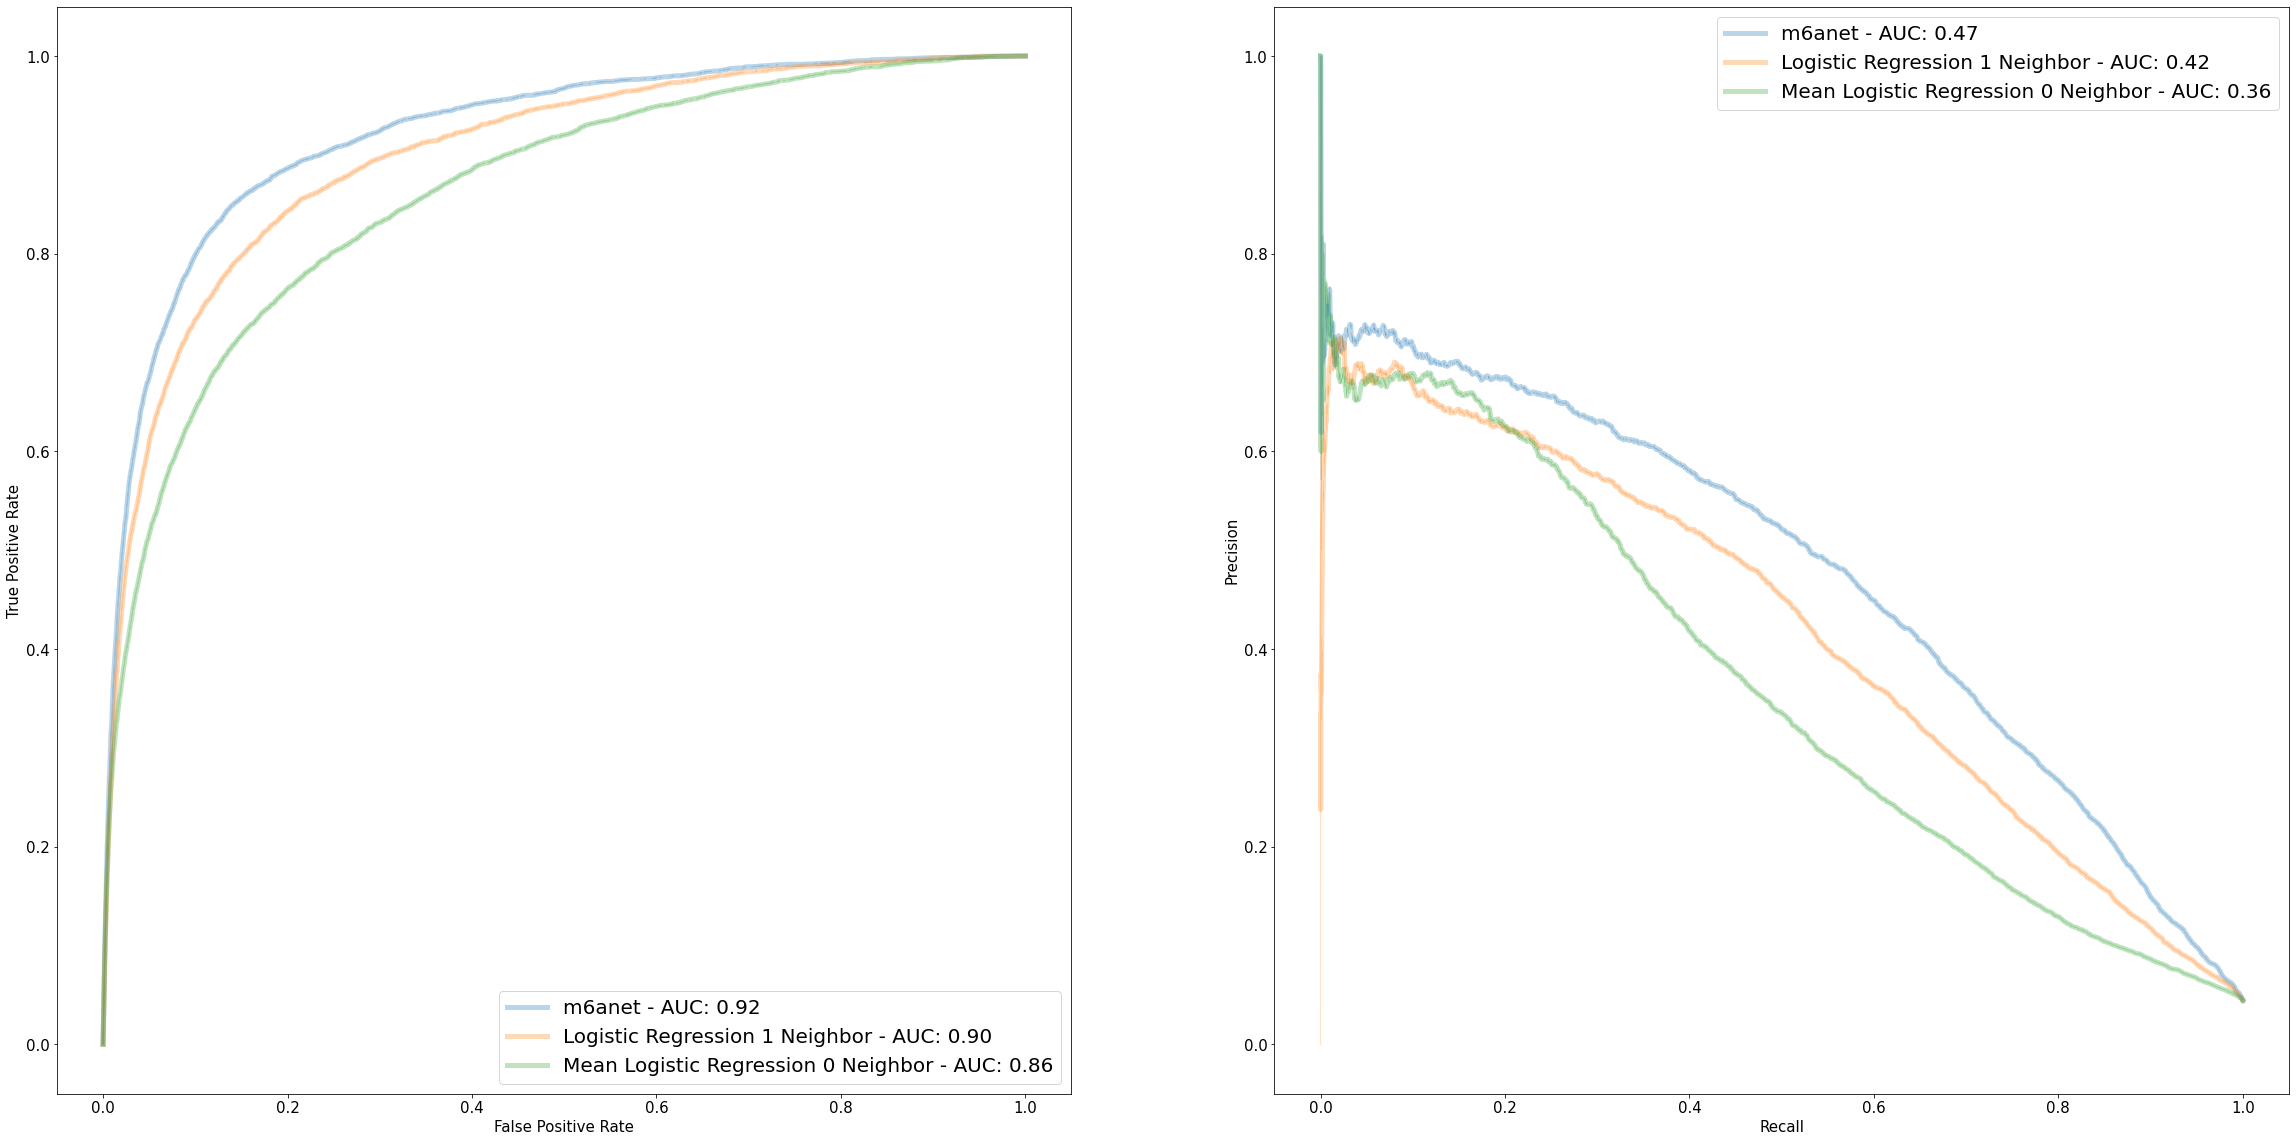

In [9]:
hct116_results = "/data03/christopher/m6anet_new_dataprep_results_cv/"
all_models = os.listdir(hct116_results)
models = ['prod_pooling_1_neighbor', 'summary_stats_logit_1_neighbor', 'mean_logit_0_neighbor']
labels = ["m6anet", "Logistic Regression 1 Neighbor", "Mean Logistic Regression 0 Neighbor"]
df = []
fig, axes = plt.subplots(1, 2, figsize=(40, 20))
for model, label in zip(models, labels):
    model_dir = os.path.join(hct116_results, model)
    for selection_criterion in ["pr_auc"]:
        y_true = []
        y_pred = []
        for fold_num in folds:
            fold_dir = os.path.join(model_dir, fold_num)
            result = joblib.load(os.path.join(fold_dir, "val_results_{}.joblib".format(selection_criterion)))
            y_true_fold, y_pred_fold = np.array(result["y_true"]), np.mean(np.array(result["y_pred"]), axis=0)
            y_true.append(y_true_fold)
            y_pred.append(y_pred_fold)
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        
        roc_auc, pr_auc = compute_roc_auc(y_true, y_pred), compute_pr_auc(y_true, y_pred)
        print(label)
        plot_roc_curve(y_true, y_pred, label, axes[0])
        plot_pr_curve(y_true, y_pred, label, axes[1])
customise_roc_pr_plots(axes)